In [60]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.kernel_approximation import RBFSampler
from sklearn.preprocessing import StandardScaler

In [57]:
# Load and read CSV file
df = pd.read_csv('gw.csv')
df.head()

,yyyymm,dfy_lag1,infl_lag1,svar_lag1,de_lag1,lty_lag1,tms_lag1,tbl_lag1,dfr_lag1,dp_lag1,dy_lag1,ltr_lag1,ep_lag1,b/m_lag1,ntis_lag1,CRSP_SPvw_minus_Rfree
0,192701,0.0100,0.000000,0.000465,-0.586175,0.0354,0.0047,0.0307,-0.0022,-2.973012,-2.956570,0.0078,-2.386837,0.441476,0.050876,-0.005410
1,192702,0.0095,-0.011299,0.000470,-0.567601,0.0351,0.0028,0.0323,-0.0019,-2.942374,-2.963349,0.0075,-2.374773,0.443706,0.050824,0.042922
2,192703,0.0092,-0.005714,0.000287,-0.549182,0.0347,0.0018,0.0329,-0.0019,-2.979535,-2.932946,0.0088,-2.430353,0.428501,0.051668,0.004324
3,192704,0.0092,-0.005747,0.000924,-0.531456,0.0331,0.0011,0.0320,-0.0170,-2.976535,-2.970053,0.0253,-2.445079,0.469765,0.046357,0.010521
4,192705,0.0090,0.000000,0.000603,-0.512916,0.0333,-0.0006,0.0339,0.0060,-2.984225,-2.967143,-0.0005,-2.471309,0.456754,0.050514,0.059353


In [59]:
y = df['CRSP_SPvw_minus_Rfree']

predictor_columns = []
for columns in df.columns:
    if columns != 'CRSP_SPvw_minus_Rfree' and columns != 'yyyymm':
        predictor_columns.append(columns)

# predictor_columns

### Part (a)

In [ ]:
# Regress each S&P returns on each predictor using full sample data
linear_model = LinearRegression()
in_sample_r2 = {}

for pred in predictor_columns:
    X = df[[pred]]
    linear_model.fit(X, y)
    y_pred = linear_model.predict(X)
    r2 = r2_score(y, y_pred)
    in_sample_r2[pred] = r2
    # print(f'Pred: {pred}, R^2: {r2}')

in_sample_results = pd.DataFrame.from_dict(in_sample_r2, orient='index', columns=['In-Sample R²'])

in_sample_results

,In-Sample R²
dfy_lag1,0.002671
infl_lag1,0.002639
svar_lag1,0.000230
de_lag1,0.000024
lty_lag1,0.002113
tms_lag1,0.001544
tbl_lag1,0.003436
dfr_lag1,0.001046
dp_lag1,0.002990
dy_lag1,0.004023


In [ ]:
# OOS performance

# Find where 1965 starts
df['year'] = df['yyyymm'] // 100
start_1965 = df[df['year'] >= 1965].index[0]

oos_r2 = {}

for pred in predictor_columns:
    predictions = []
    actuals = []
    
    for t in range(start_1965, len(df)):
        # Train on all data BEFORE time t
        X_train = df.loc[:t-1, [pred]]
        y_train = y.iloc[:t]
        
        # Test on time t
        X_test = df.loc[[t], [pred]]
        y_test = y.iloc[t]
        
        # Fit and predict
        linear_model.fit(X_train, y_train)
        y_pred = linear_model.predict(X_test)[0]
        predictions.append(y_pred)
        actuals.append(y_test)
    
    # Calculate R^2
    r2 = r2_score(actuals, predictions)
    oos_r2[pred] = r2
    # print(f'Pred: {pred}, OOS R^2: {r2:.6f}')

oos_results = pd.DataFrame.from_dict(oos_r2, orient='index', columns=['Out-of-Sample R²'])

oos_results


,Out-of-Sample R²
dfy_lag1,-0.000669
infl_lag1,0.000713
svar_lag1,-0.009895
de_lag1,-0.011581
lty_lag1,-0.007292
tms_lag1,-0.002814
tbl_lag1,-0.001042
dfr_lag1,-0.005938
dp_lag1,-0.007564
dy_lag1,-0.011630


In [ ]:
# Combine R^2 results to a single df to compare
result = pd.concat([in_sample_results, oos_results], axis=1)
result

,In-Sample R²,Out-of-Sample R²
dfy_lag1,0.002671,-0.000669
infl_lag1,0.002639,0.000713
svar_lag1,0.000230,-0.009895
de_lag1,0.000024,-0.011581
lty_lag1,0.002113,-0.007292
tms_lag1,0.001544,-0.002814
tbl_lag1,0.003436,-0.001042
dfr_lag1,0.001046,-0.005938
dp_lag1,0.002990,-0.007564
dy_lag1,0.004023,-0.011630


The OOS results are nearly all negative. This means that these predictors have little to no  forecasting power for future market returns. A negative OOS R^2 indicates that using these predictors to forecast returns performs worse than just using historical mean return. 

While the in sample R^2 show a positive relationship, they do not persist oos. Patterns typically persist oos which we do not see here. This suggests that in-sample relationships are likely capturing noise instead of a true predictive signal. 

There are large gaps between in-sample and oos performance. For example in b\m_lag1, the R^2 drops from 0.006 to -0.034 (~0.04 drop). This demonstrates overfitting where the model is fitting to random patterns in the data that do not apply to new time periods


### Part (b)

In [40]:
# OOS OLS with all predictors

predictions = []
actuals = []

for t in range(start_1965, len(df)):
    # Train on all data BEFORE time t
    X_train = df.loc[:t-1, predictor_columns]
    y_train = y.iloc[:t]
        
    # Test on time t
    X_test = df.loc[[t], predictor_columns]
    y_test = y.iloc[t]
        
    # Fit and predict
    linear_model.fit(X_train, y_train)
    y_pred = linear_model.predict(X_test)[0]
    predictions.append(y_pred)
    actuals.append(y_test)
    
# Calculate R^2
oos_all_r2 = r2_score(actuals, predictions)

unpenalized_predictions = predictions.copy()
unpenalized_actuals = actuals.copy()

print("OOS R² All Predictors:", oos_all_r2)


OOS R² All Predictors: -0.08629457715030675


This R^2 is much worse than all of the previously calculated OOS R^2. The difference between the lowest individual predictor R^2 and all of the predictors R^2 is 0.052.

This demonstrates overfitting. Including all the predictors allows the model to take into account more noise and therefore lead us to a lower R^2.

In [35]:
# Defining parameters
alphas = np.logspace(-4, 2, 50)

# Lasso, Ridge, Elastic net using CV 
# GridSearchCV automatically performs K-fold cross-validation

lasso_cv = GridSearchCV(Lasso(max_iter=10000), 
                        param_grid={'alpha': alphas}, 
                        cv=5, 
                        scoring='r2')

ridge_cv = GridSearchCV(Ridge(), 
                        param_grid={'alpha': alphas}, 
                        cv=5, 
                        scoring='r2')

elastic_cv = GridSearchCV(ElasticNet(max_iter=10000), 
                          param_grid={'alpha': alphas, 'l1_ratio': [0.5]}, 
                          cv=5, 
                          scoring='r2')

models = {'Lasso': lasso_cv, 'Ridge': ridge_cv, 'Elastic Net': elastic_cv}


all_predictions = {}
all_actuals = []
oos_results = {}

for name, model in models.items():
    predictions = []
    actuals = []
    
    for t in range(start_1965, len(df)):
        X_train = df.loc[:t-1, predictor_columns]
        y_train = y.iloc[:t]
        
        X_test = df.loc[[t], predictor_columns]
        y_test = y.iloc[t]
        
        # Fit with CV
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)[0]
        
        predictions.append(y_pred)
        actuals.append(y_test)

    all_predictions[name] = predictions
    if name == 'Lasso':
        all_actuals = actuals  # same for all models
    
    r2 = r2_score(actuals, predictions)
    oos_results[name] = r2
    print(f"{name} OOS R²: {r2:.6f}")

Lasso OOS R²: -0.008962
Ridge OOS R²: -0.014405
Elastic Net OOS R²: -0.008032


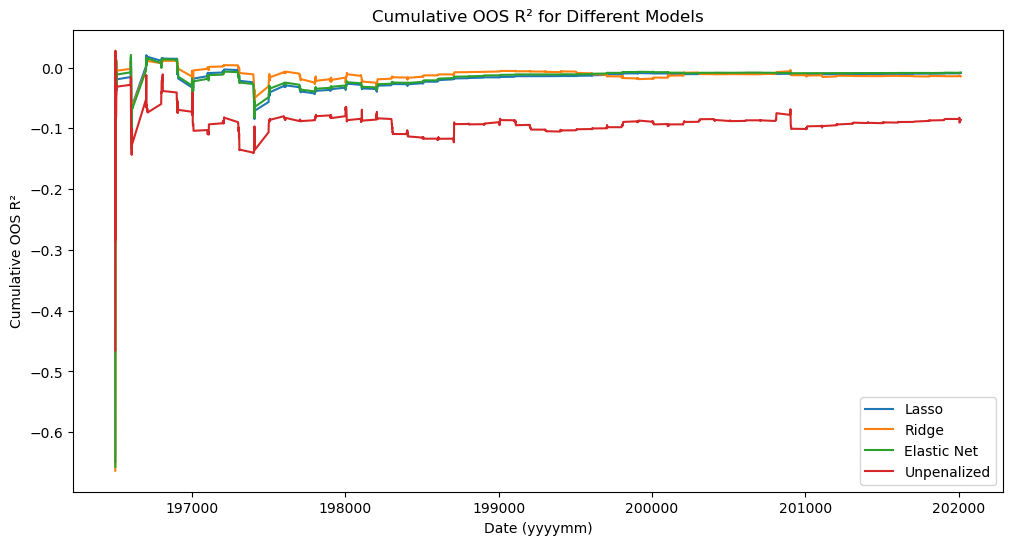

In [42]:
# Plot all OOS R^2 results to compare

# Add unpenalized regression results to dictionary
all_predictions['Unpenalized'] = unpenalized_predictions

# Calculate cumulative R^2 for each model
cumulative_r2 = {}
for name, preds in all_predictions.items():
    r2 = r2_score(all_actuals, preds)
    cumulative_r2[name] = []
    for i in range(1, len(preds)):
        r2 = r2_score(all_actuals[:i+1], preds[:i+1])
        cumulative_r2[name].append(r2)

# Plot cumulative R^2
dates = df.loc[start_1965+1:, 'yyyymm'].values # +1 because predictions start from start_1965
plt.figure(figsize=(12, 6))
for name in all_predictions.keys():
    plt.plot(dates, cumulative_r2[name], label=name)
plt.xlabel('Date (yyyymm)')
plt.ylabel('Cumulative OOS R²')
plt.title('Cumulative OOS R² for Different Models')
plt.legend()
plt.show()

From the plot, we can see that the penalized methods outperform the unpenalized R^2 results with R^2s much closer to 0. This means that regularization was successful in reducing overfitting by shrinking coefficients. 

However even the best penalized method, still has R^2 near 0 or slightly negative. This suggests that it is difficult to predict market returns using these predictors.

This is consistent with the efficient market hypothesis. If returns are easily predicatble using public information, then investors would exploit these patterns until they disappeared. The near-zero R^2 could be an indication that predictable patterns are already incorporated into prices. 

Simply put, there is very little predictable signal in stock returns relative to noise. 

### Part (c)

In [61]:
# RBF Kernel Regression OOS R^2
n_features_list = [10, 25, 50, 100, 200]
rbf_oos_r2 = {}

for n_features in n_features_list:
    
    predictions = []
    actuals = []
    
    for t in range(start_1965, len(df)):
        X_train = df.loc[:t-1, predictor_columns]
        y_train = y.iloc[:t]
        X_test = df.loc[[t], predictor_columns]
        y_test = y.iloc[t]
        
        # STANDARDIZE first!
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Generate RBF features
        rbf = RBFSampler(n_components=n_features, random_state=42)
        X_train_rbf = rbf.fit_transform(X_train_scaled)
        X_test_rbf = rbf.transform(X_test_scaled)
        
        # Fit model
        model = LinearRegression()
        model.fit(X_train_rbf, y_train)
        y_pred = model.predict(X_test_rbf)[0]
        
        predictions.append(y_pred)
        actuals.append(y_test)
    
    r2 = r2_score(actuals, predictions)
    rbf_oos_r2[n_features] = r2
    print(f"RBF with {n_features} features - OOS R²: {r2:.6f}")

RBF with 10 features - OOS R²: -0.033377
RBF with 25 features - OOS R²: -0.077950
RBF with 50 features - OOS R²: -0.139097
RBF with 100 features - OOS R²: -0.357021
RBF with 200 features - OOS R²: -0.863734


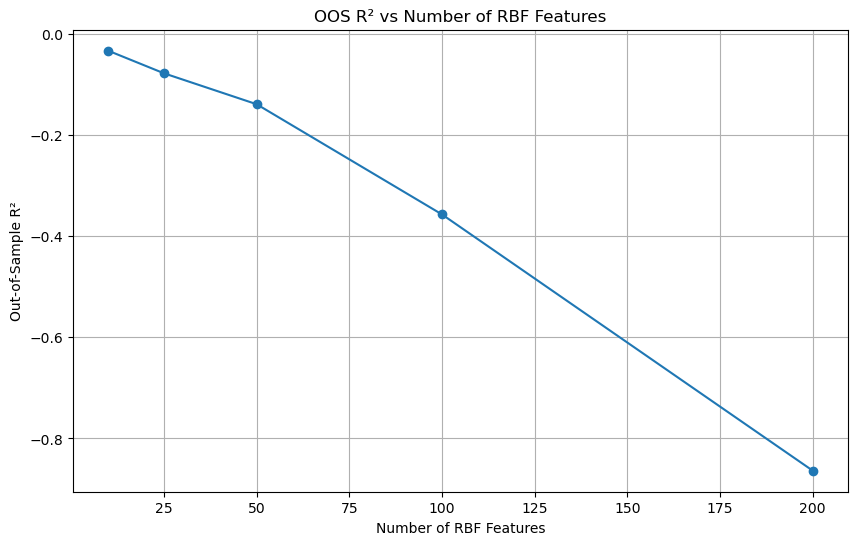

In [49]:
# Plot OOS of RBF features
plt.figure(figsize=(10, 6))
plt.plot(list(rbf_oos_r2.keys()), list(rbf_oos_r2.values()), marker='o')
plt.xlabel('Number of RBF Features')
plt.ylabel('Out-of-Sample R²')
plt.title('OOS R² vs Number of RBF Features')
plt.grid(True)
plt.show()

The RBF kernel R^2s are slightly worse than the linear models overall. The best RBF occurs with 10 features and has an R^2 of -0.033. This is comparable to the linear models but still worse than them. The linear models have R^2 much closer to 0 (R^2 of elastic net: -0.008).

Looking at the plot above, the importance of the number of features is clear: fewer features is better. The addition of features may give the model flexibility to overfit and take into account more noise, which makes predictions worse.

** did not include RBF with 500 features because the R^2 was dramatically much smaller than up to 200.

### Part (d)

In [62]:
# RBF Analysis with rolling windows

window_size = [12, 36, 60, 120]
n_features = 10 # best performing from above

rolling_rbf_results = {}

for window in window_size:
    
    predictions = []
    actuals = []
    
    for t in range(start_1965, len(df)):
        # Skip if we don't have enough history yet
        if t < start_1965 + window:
            continue
        
        train_start = t - window
        X_train = df.loc[train_start:t-1, predictor_columns]
        y_train = y.iloc[train_start:t]
        
        X_test = df.loc[[t], predictor_columns]
        y_test = y.iloc[t]
        
        # STANDARDIZE first!
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Generate RBF features
        rbf = RBFSampler(n_components=n_features, random_state=42)
        X_train_rbf = rbf.fit_transform(X_train_scaled)
        X_test_rbf = rbf.transform(X_test_scaled)
        
        # Fit model
        linear_model.fit(X_train_rbf, y_train)
        y_pred = linear_model.predict(X_test_rbf)[0]

        predictions.append(y_pred)
        actuals.append(y_test)
    
    r2 = r2_score(actuals, predictions)
    rolling_rbf_results[window] = r2
    print(f"Sliding Window {window} OOS R²: {r2:.6f}")

Sliding Window 12 OOS R²: -30.165765
Sliding Window 36 OOS R²: -0.461333
Sliding Window 60 OOS R²: -0.174383
Sliding Window 120 OOS R²: -0.138312
